# Environment Setup

In [6]:
# Install necessary libraries
!pip install timm  # for ConvNeXt models

# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# Mount Google Drive

In [17]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the base path for accessing the dataset from Google Drive
dataset_base_path = '/content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main/custom_dateset'  # Double-check this path
train_dir = f'{dataset_base_path}/train'
test_dir = f'{dataset_base_path}/test'

# Check if the train and test directories exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Training directory '{train_dir}' not found. Please check the path.")
else:
    print(f"Training directory exists: {train_dir}")

if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Testing directory '{test_dir}' not found. Please check the path.")
else:
    print(f"Testing directory exists: {test_dir}")

# Check contents of directories
print("Contents of training directory:")
!ls "$train_dir"

print("\nContents of testing directory:")
!ls "$test_dir"


Mounted at /content/drive
Training directory exists: /content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main/custom_dateset/train
Testing directory exists: /content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main/custom_dateset/test
Contents of training directory:
Crazing  Inclusion  Patches  Pitted  Rolled  Scratches

Contents of testing directory:
Crazing  Inclusion  Patches  Pitted  Rolled  Scratches


# Load Pre-trained Model

In [25]:
# Step 2: Load the Pre-trained ConvNeXt Model
# Load ConvNeXt with pre-trained weights from timm and set it to use CUDA if available.
import torch
import timm
from torch import nn

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ConvNeXt model with pretrained weights from timm library
model = timm.create_model('convnext_base', pretrained=True, num_classes=0)  # Set num_classes to 0 to remove the default classifier
model = model.to(device)

# Step 3: Freeze Layers for Transfer Learning
# We only want to fine-tune the classifier head, so we freeze other layers.
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head to match the number of classes in your dataset
num_classes = len(['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches'])
in_features = model.num_features  # timm models use num_features for the output feature size

# Step 4: Modify the Classifier Head
# Replace the default head with a new classifier suitable for our specific dataset with 6 classes.
model.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),  # Add a global average pooling layer
    nn.Flatten(),             # Flatten the tensor to prepare it for the linear layer
    nn.Linear(in_features, num_classes)  # Fully connected layer with the correct input-output size
)

model = model.to(device)

# Check the model summary to confirm the changes
print(model)


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

# Dataset Preparation

In [26]:
# Step 5: Dataset Preparation
# Importing libraries for data transformation and data loading. Set up data augmentation for training and validation data.
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

class_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

# Data augmentation and transformation for training and validation data
train_transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize to target size (ViT usually expects 224x224)
      transforms.RandomRotation(degrees=(-45, 45)),  # Random rotation in range [-45, 45] degrees for more visibility
      transforms.RandomHorizontalFlip(p=0.5),  # X Reflection with probability 0.5
      transforms.RandomVerticalFlip(p=0.5),  # Y Reflection with probability 0.5
      transforms.RandomAffine(degrees=0, shear=(-5, 5, -5, 5)),  # X Shear and Y Shear in range [-5, 5]
      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation by up to 10% in both X and Y directions
      transforms.ToTensor(),  # Convert to Tensor
     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])
# Step 6: Load the Dataset
# Load custom dataset from Google Drive or local storage. Split into train and test sets.

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count())


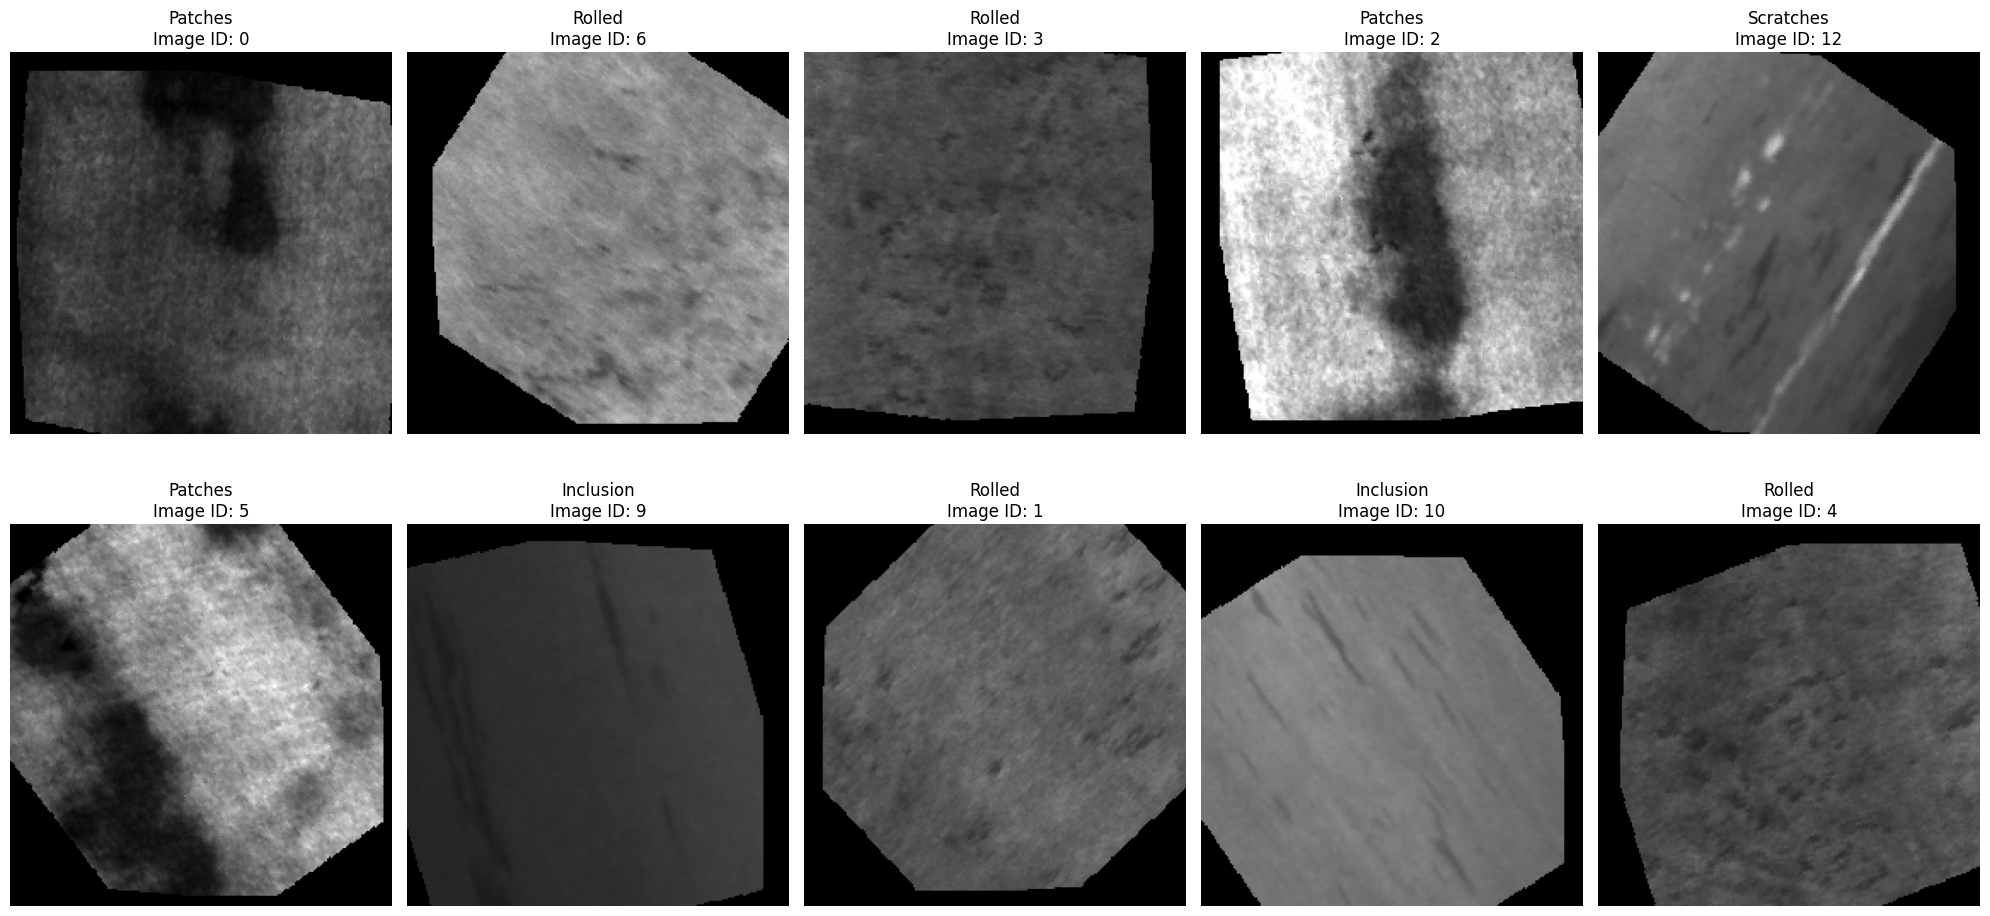


Details of 10 Random Images:
Image ID: 0, Class: Patches
Image ID: 6, Class: Rolled
Image ID: 3, Class: Rolled
Image ID: 2, Class: Patches
Image ID: 12, Class: Scratches
Image ID: 5, Class: Patches
Image ID: 9, Class: Inclusion
Image ID: 1, Class: Rolled
Image ID: 10, Class: Inclusion
Image ID: 4, Class: Rolled


In [27]:
import matplotlib.pyplot as plt
import random

# Assuming 'train_dataloader_pretrained' is already defined
# Get a batch of images
image_batch, label_batch = next(iter(train_loader))

# Display 10 random images from the batch
plt.figure(figsize=(20, 10))

# Select 10 random indices from the batch
random_indices = random.sample(range(len(image_batch)), 10)

for i, idx in enumerate(random_indices):
    image, label = image_batch[idx], label_batch[idx]

    # Rearrange image dimensions for matplotlib (from C x H x W to H x W x C)
    image = image.permute(1, 2, 0)

    # Display the image with title as the class name
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"{class_names[label]}\nImage ID: {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Display image class and filename for each selected image
print("\nDetails of 10 Random Images:")
for idx in random_indices:
    label = label_batch[idx]
    print(f"Image ID: {idx}, Class: {class_names[label]}")


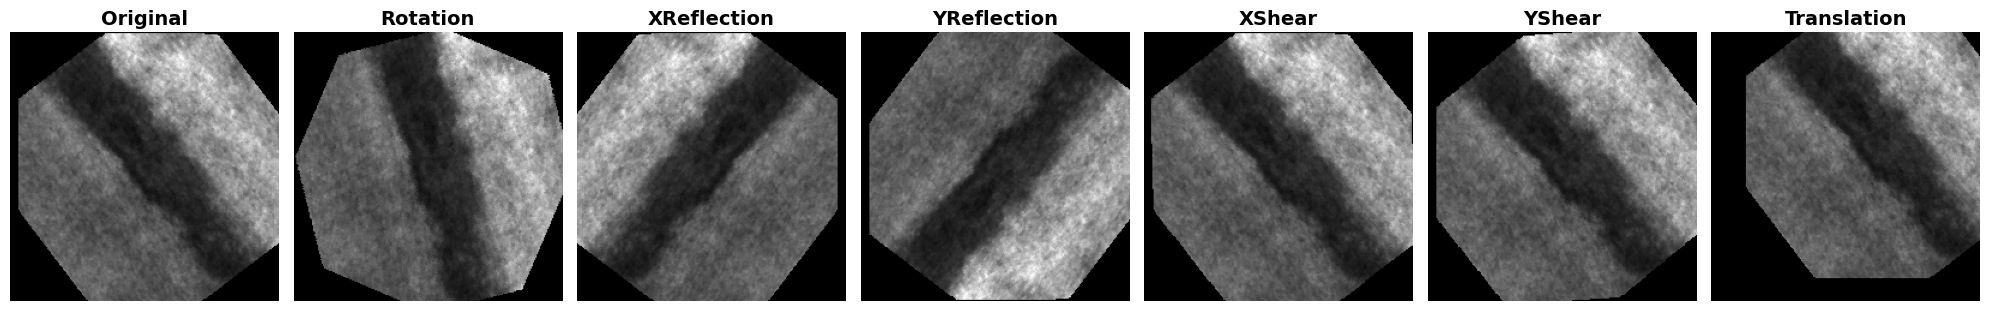

In [28]:
from torchvision import transforms
import matplotlib.pyplot as plt
import random

# Load an example image from the training dataset
random_index = random.randint(0, len(train_dataset) - 1)

# Access the image and label using the random index
original_image, label = train_dataset[random_index]

class_name = train_dataset.classes[label]

# Convert the original tensor image to a PIL Image
to_pil = transforms.ToPILImage()
original_image_pil = to_pil(original_image)  # Convert to PIL for visualization and transformation

# Define data augmentation transformations
augmentation_transformations = {
    "Rotation": transforms.RandomRotation(degrees=(-45, 45)),
    "XReflection": transforms.RandomHorizontalFlip(p=1.0),
    "YReflection": transforms.RandomVerticalFlip(p=1.0),
    "XShear": transforms.RandomAffine(degrees=0, shear=(-5, 5, 0, 0)),
    "YShear": transforms.RandomAffine(degrees=0, shear=(0, 0, -5, 5)),
    "Translation": transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
}

# Plot original and augmented versions
def plot_augmentations(original_image_pil, augmentation_transformations):
    num_transforms = len(augmentation_transformations)
    fig, axes = plt.subplots(1, num_transforms + 1, figsize=(20, 5))

    # Plot the original image
    axes[0].imshow(original_image_pil)
    axes[0].set_title("Original", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Plot transformed images with their respective labels
    for i, (transform_name, transform) in enumerate(augmentation_transformations.items(), start=1):
        augmented_image_pil = transform(original_image_pil)
        axes[i].imshow(augmented_image_pil)
        axes[i].set_title(transform_name, fontsize=14, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Use the updated function to plot the augmentations
plot_augmentations(original_image_pil, augmentation_transformations)


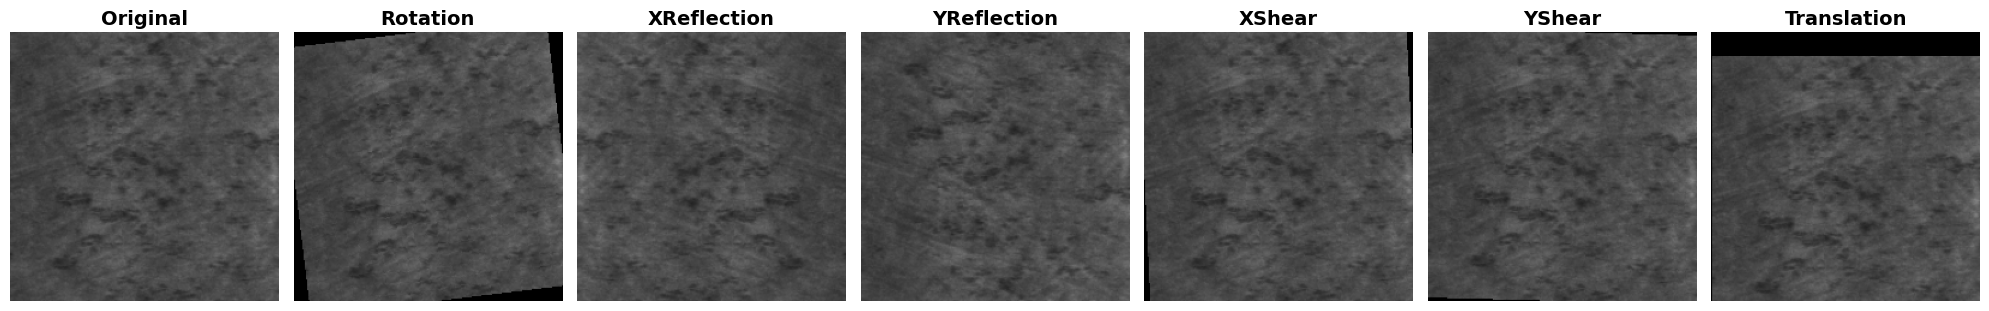

In [29]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np

# Basic transform for visualization (no augmentation)
visual_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a consistent size
    transforms.ToTensor(),  # Convert to tensor
])

# Load an example image from the training dataset
random_index = random.randint(0, len(train_dataset) - 1)

# Access the original image and label using the basic transform
# This ensures we get a non-augmented version of the original image
original_image, label = datasets.ImageFolder(root=train_dir, transform=visual_transform)[random_index]
class_name = train_dataset.classes[label]

# Convert the original tensor image to a PIL Image for plotting
to_pil = transforms.ToPILImage()
original_image_pil = to_pil(original_image)

# Define data augmentation transformations
augmentation_transformations = {
    "Rotation": transforms.Compose([transforms.RandomRotation(degrees=(-45, 45)), transforms.ToTensor()]),
    "XReflection": transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
    "YReflection": transforms.Compose([transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor()]),
    "XShear": transforms.Compose([transforms.RandomAffine(degrees=0, shear=(-5, 5, 0, 0)), transforms.ToTensor()]),
    "YShear": transforms.Compose([transforms.RandomAffine(degrees=0, shear=(0, 0, -5, 5)), transforms.ToTensor()]),
    "Translation": transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ToTensor()])
}

# Plot original and augmented versions
def plot_augmentations(original_image_pil, augmentation_transformations):
    num_transforms = len(augmentation_transformations)
    fig, axes = plt.subplots(1, num_transforms + 1, figsize=(20, 5))

    # Plot the original image
    axes[0].imshow(original_image_pil)
    axes[0].set_title("Original", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Plot transformed images with their respective labels
    for i, (transform_name, transform) in enumerate(augmentation_transformations.items(), start=1):
        # Apply the transformation to the original image
        augmented_image = transform(original_image_pil)

        # Convert back to numpy for plotting (from CxHxW to HxWxC)
        augmented_image_np = augmented_image.permute(1, 2, 0).numpy()

        # Clip the image to be in the valid range [0, 1]
        augmented_image_np = np.clip(augmented_image_np, 0, 1)

        # Plotting the augmented image
        axes[i].imshow(augmented_image_np)
        axes[i].set_title(transform_name, fontsize=14, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Use the updated function to plot the augmentations
plot_augmentations(original_image_pil, augmentation_transformations)


# Define Optimizer and Loss Function

In [30]:
# Step 7: Define Optimizer and Loss Function
# Using AdamW optimizer and Cross Entropy loss function.
from torch.optim import AdamW

# Create optimizer for only the head
optimizer = AdamW(model.head.parameters(), lr=1e-4, weight_decay=1e-2)  # Adjust learning rate as needed
loss_fn = nn.CrossEntropyLoss()


# Training Loop

In [31]:
# Step 8: Training Loop
# Train the ConvNeXt model over multiple epochs. Track training and validation loss and accuracy.

num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # The output shape should now match the head's expectation
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions.double() / total_samples

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    val_loss /= len(test_loader.dataset)
    val_accuracy = correct_predictions.double() / total_samples

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy.item() * 100)
    val_accuracies.append(val_accuracy.item() * 100)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1/50, Train Loss: 1.1193, Train Acc: 0.6233, Val Loss: 0.6203, Val Acc: 0.8033
Epoch 2/50, Train Loss: 0.5241, Train Acc: 0.8749, Val Loss: 0.4155, Val Acc: 0.8587
Epoch 3/50, Train Loss: 0.3354, Train Acc: 0.9333, Val Loss: 0.2917, Val Acc: 0.9197
Epoch 4/50, Train Loss: 0.2486, Train Acc: 0.9618, Val Loss: 0.2199, Val Acc: 0.9418
Epoch 5/50, Train Loss: 0.2098, Train Acc: 0.9653, Val Loss: 0.1870, Val Acc: 0.9474
Epoch 6/50, Train Loss: 0.1647, Train Acc: 0.9805, Val Loss: 0.1595, Val Acc: 0.9557
Epoch 7/50, Train Loss: 0.1555, Train Acc: 0.9778, Val Loss: 0.1383, Val Acc: 0.9668
Epoch 8/50, Train Loss: 0.1327, Train Acc: 0.9854, Val Loss: 0.1247, Val Acc: 0.9695
Epoch 9/50, Train Loss: 0.1067, Train Acc: 0.9826, Val Loss: 0.1153, Val Acc: 0.9723
Epoch 10/50, Train Loss: 0.1014, Train Acc: 0.9882, Val Loss: 0.0989, Val Acc: 0.9751
Epoch 11/50, Train Loss: 0.0928, Train Acc: 0.9861, Val Loss: 0.0912, Val Acc: 0.9778
Epoch 12/50, Train Loss: 0.0857, Train Acc: 0.9910, Val Loss: 0

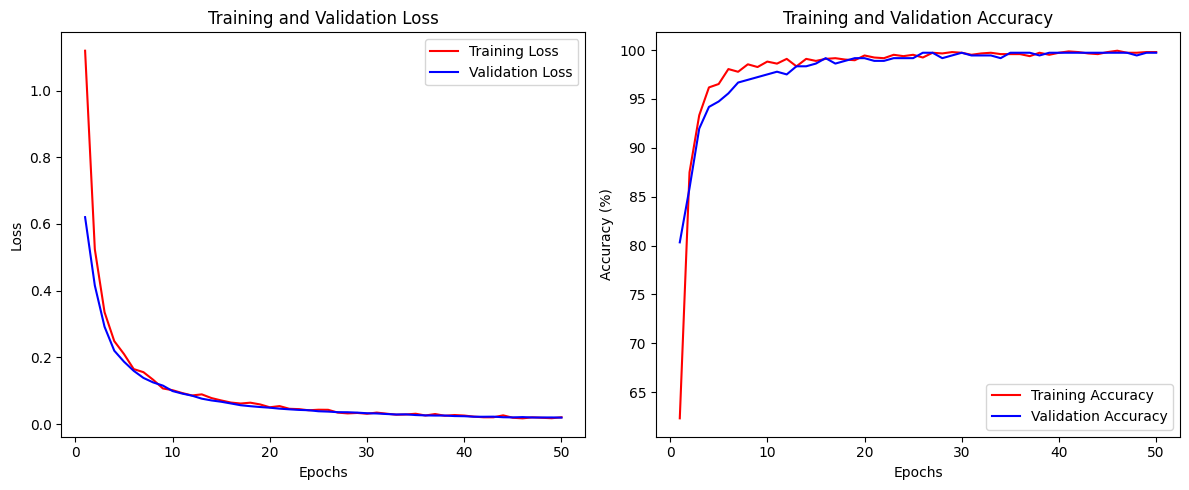

In [32]:
# Plot Loss and Accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='red')
    plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='red')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


# Evaluation and Result Visualization

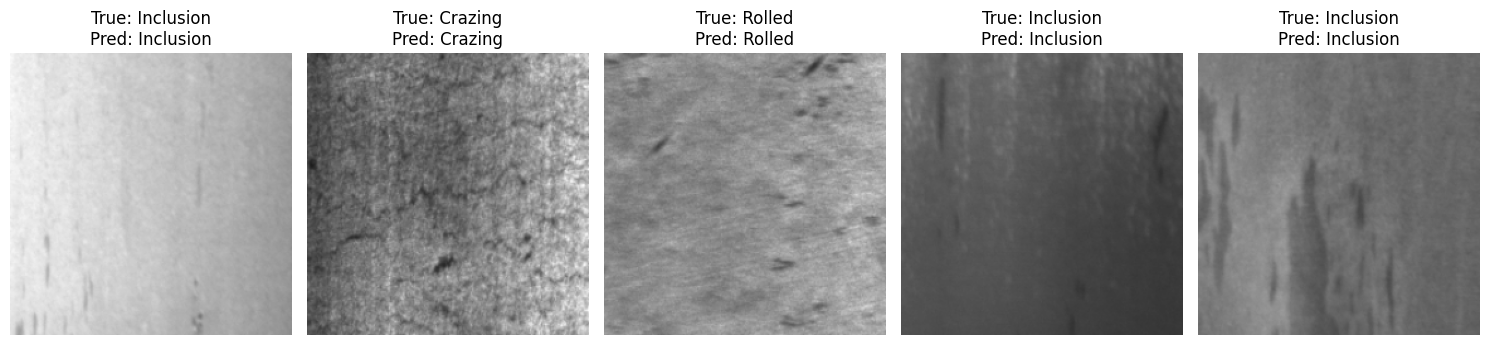

In [33]:
import matplotlib.pyplot as plt
import torch
import random

def predict_image(model, dataloader, class_names, device="cpu", num_images=5):
    """Displays predictions of a trained model on randomly selected images from the dataset."""
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        # Randomly select images from the test dataloader
        all_inputs, all_labels = [], []
        for inputs, labels in dataloader:
            all_inputs.append(inputs)
            all_labels.append(labels)

        all_inputs = torch.cat(all_inputs)
        all_labels = torch.cat(all_labels)
        indices = list(range(len(all_inputs)))
        random.shuffle(indices)

        for idx in indices:
            if images_shown == num_images:
                break

            input_img = all_inputs[idx].unsqueeze(0).to(device)
            label = all_labels[idx].item()
            output = model(input_img)
            _, predicted = torch.max(output, 1)

            # Convert to CPU for plotting
            image = input_img[0].cpu().permute(1, 2, 0).numpy()
            true_label = class_names[label]
            predicted_label = class_names[predicted.item()]

            ax = fig.add_subplot(1, num_images, images_shown + 1)
            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {predicted_label}')
            ax.axis('off')
            images_shown += 1

    plt.tight_layout()
    plt.show()

# Use the predict_image function
predict_image(model=model, dataloader=test_loader, class_names=train_dataset.classes, device=device)


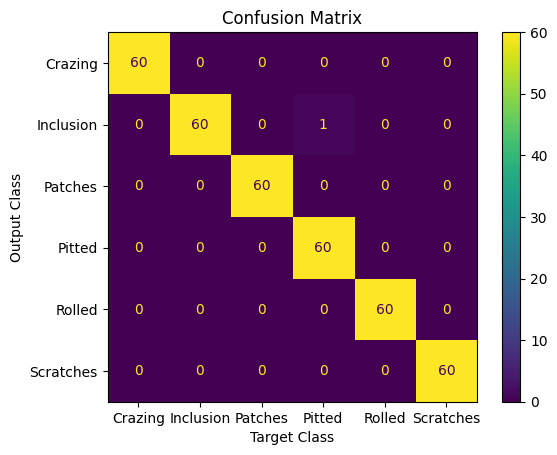

Classification Report:
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        60
   Inclusion       1.00      0.98      0.99        61
     Patches       1.00      1.00      1.00        60
      Pitted       0.98      1.00      0.99        60
      Rolled       1.00      1.00      1.00        60
   Scratches       1.00      1.00      1.00        60

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361



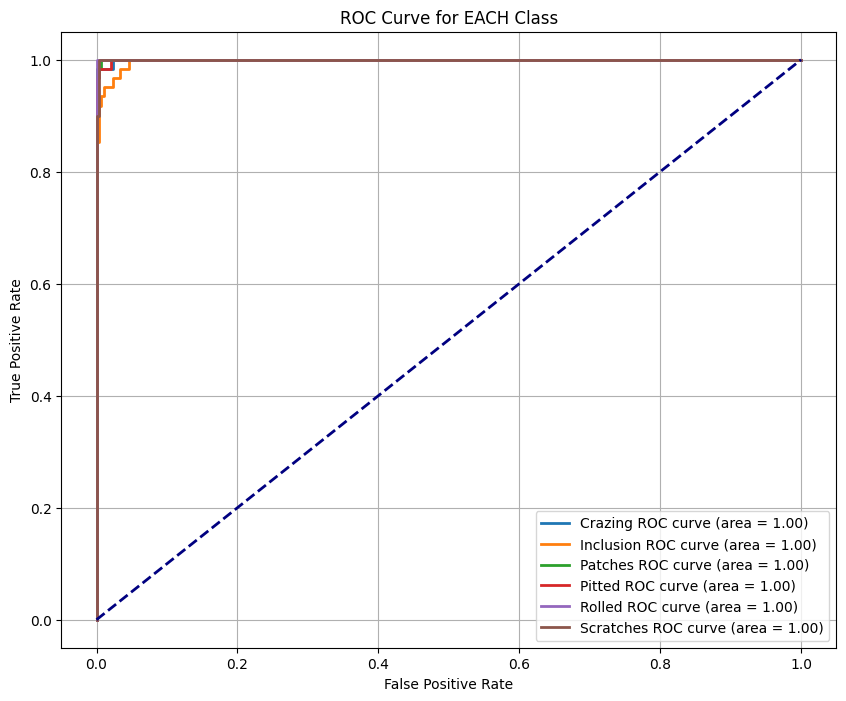

Model Evaluation Metrics:
Accuracy (AC): 99.72%
Sensitivity (SE): 98.36%
Specificity (SP): 100.00%
Error Rate (ER): 0.28%


In [34]:
# Step 9: Evaluation and Result Visualization
# Evaluate model performance using metrics like accuracy, AUC, etc. Visualize the results using graphs and confusion matrices.

import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def evaluate_model(model, dataloader, class_names, device="cpu"):
    """Evaluates a trained PyTorch model and produces evaluation metrics and graphs.

    Args:
        model (torch.nn.Module): Trained model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader containing test data.
        class_names (list): List of class names.
        device (str, optional): Device to perform evaluation on. Defaults to "cpu".

    Returns:
        None: Displays confusion matrix, classification report, ROC curve, and accuracy/loss graphs.
    """
    model.eval()
    y_true = []
    y_pred = []
    y_score = []

    # Collect predictions
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_score.extend(outputs.cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.xlabel("Target Class")
    plt.ylabel("Output Class")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calculate AUC, Accuracy, Sensitivity, Specificity, and Error Rate
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    accuracy = np.mean(y_true_np == y_pred_np)

    # One-vs-Rest ROC Curve for Multiclass Classification
    y_true_bin = label_binarize(y_true_np, classes=np.unique(y_true_np))
    y_score_np = np.array(y_score)
    n_classes = y_true_bin.shape[1]

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score_np[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for EACH Class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Sensitivity and Specificity Calculation
    sensitivity = np.sum((y_true_np == 1) & (y_pred_np == 1)) / np.sum(y_true_np == 1)
    specificity = np.sum((y_true_np == 0) & (y_pred_np == 0)) / np.sum(y_true_np == 0)
    error_rate = 1 - accuracy

    print(f"Model Evaluation Metrics:")
    print(f"Accuracy (AC): {accuracy * 100:.2f}%")
    print(f"Sensitivity (SE): {sensitivity * 100:.2f}%")
    print(f"Specificity (SP): {specificity * 100:.2f}%")
    print(f"Error Rate (ER): {error_rate * 100:.2f}%")

# Use the evaluate_model function
evaluate_model(model=model, dataloader=test_loader, class_names=train_dataset.classes, device=device)


# Save the Model

In [35]:
# Step 10: Save the Model
# Save the trained model for future use.
# Define a path to save the model (you can change this path as per your requirements)
save_path = "/content/drive/MyDrive/ViTs/convnext_trained_model.pth"

# Save the model's state dictionary (recommended)
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/ViTs/convnext_trained_model.pth
